# PM2.5 feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PATH="BeijingPM_imputed.csv"

data=pd.read_csv(DATASET_PATH)

data.index=pd.DatetimeIndex(data["date"])

valcols=data.columns
lblcols=["id","date","year","month","day","hour","season","cbwd"]
valcols^=lblcols

## Data value distribution

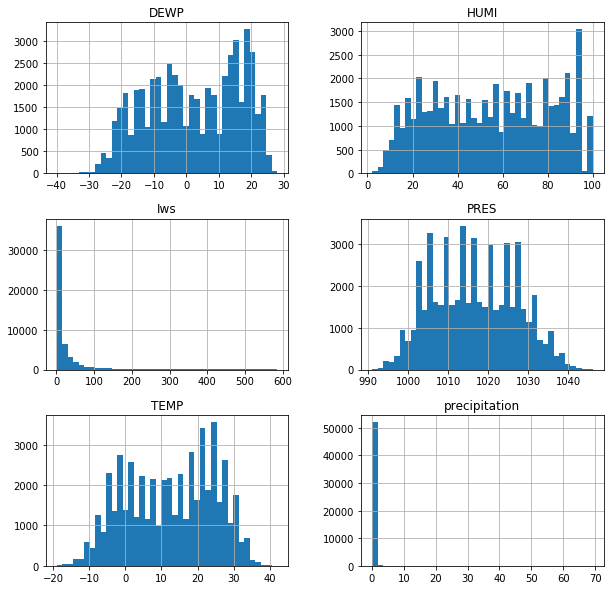

In [2]:
_=data.hist(bins=40,figsize=(10,10),column=valcols^["PM"])

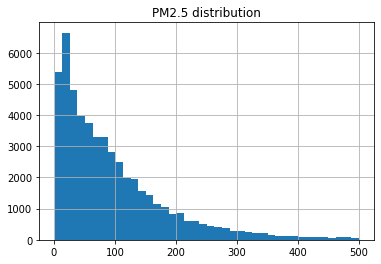

In [3]:
_=data["PM"].hist(bins=40).set_title("PM2.5 distribution")

We can see that our PM2.5 approximately follows a pattern of exponential distribution, implying that Beijing has favorable air quality most of the time.

## Box plot

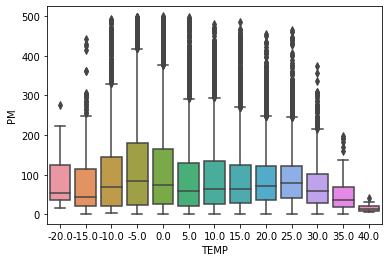

In [4]:
sns.boxplot(x=data["TEMP"]//5*5,y=data["PM"])

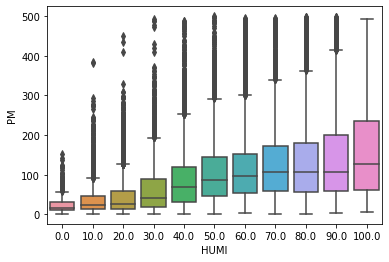

In [5]:
sns.boxplot(x=data["HUMI"]//10*10,y=data["PM"])

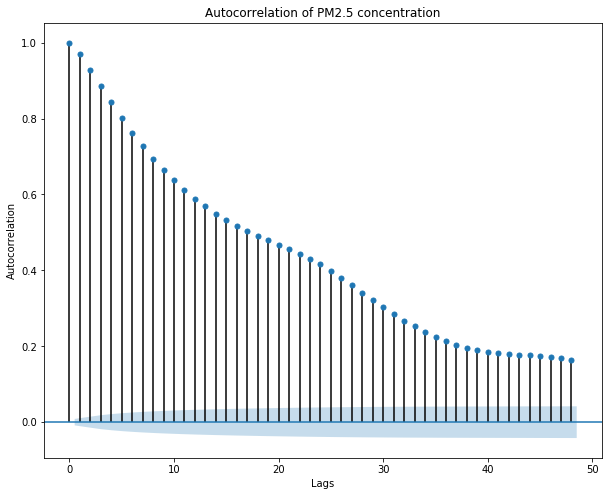

In [6]:
import statsmodels.api as sm

f=plt.figure(figsize=(10,8))
ax=f.gca()
ax.set_xlabel("Lags")
ax.set_ylabel("Autocorrelation")
_=sm.graphics.tsa.plot_acf(data["PM"],title="Autocorrelation of PM2.5 concentration",ax=ax)

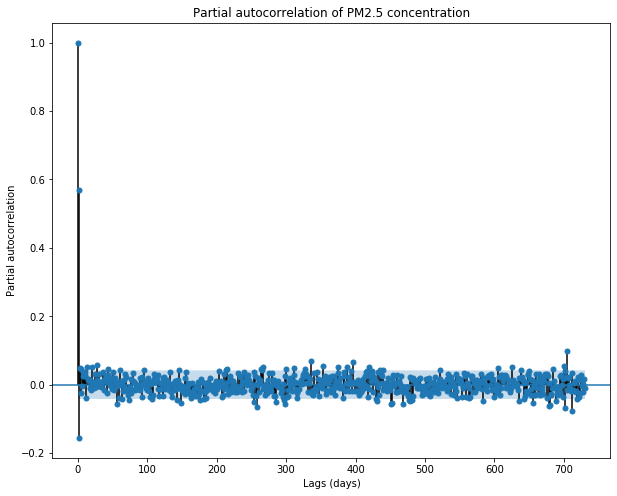

In [7]:
data["_date"]=pd.to_datetime(data[["year","month","day"]])
daily_avg=data.groupby("_date").mean()["PM"]
data.drop("_date",axis=1,inplace=True)

f=plt.figure(figsize=(10,8))
ax=f.gca()
ax.set_xlabel("Lags (days)")
ax.set_ylabel("Partial autocorrelation")
_=sm.graphics.tsa.plot_pacf(daily_avg,lags=2*365,title="Partial autocorrelation of PM2.5 concentration",ax=ax)
plt.savefig("graphs/pm_pacf.pdf")
plt.savefig("graphs/pm_pacf.png")

## Generate lagged features based on partial autocorrelation

In [8]:
pm_pacf=sm.tsa.stattools.pacf(daily_avg,nlags=365*2)
pm_pacf.shape

(731,)

In [9]:
pm_pacf_series=pd.Series(abs(pm_pacf),index=range(pm_pacf.shape[0]))
pm_pacf_series.sort_values(ascending=False).head(10)

0      1.000000
1      0.568508
2      0.156106
705    0.099613
712    0.078440
702    0.068307
336    0.068134
397    0.067089
258    0.066680
679    0.062429
dtype: float64

In [10]:
def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + "_lag" + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

lag_size=48

data_lagged=lagged_features(data[["PM","TEMP","PRES","precipitation"]],range(1,lag_size+1))

## Trend and seasonality

Time series can often be decomposed into two components: Trend and seasonality. In this notebook, we use `seasonal_decompose()` provided by Python package `statsmodels` to perform relevant analysis. Because the dataset contains a great number of entries, the results are truncated for better visualization.

In [11]:
help(pd.Series.first_valid_index)

Help on function first_valid_index in module pandas.core.generic:

first_valid_index(self)
    Return index for first non-NA/null value.
    
    Returns
    -------
    scalar : type of index
    
    Notes
    -----
    If all elements are non-NA/null, returns None.
    Also returns None for empty Series/DataFrame.



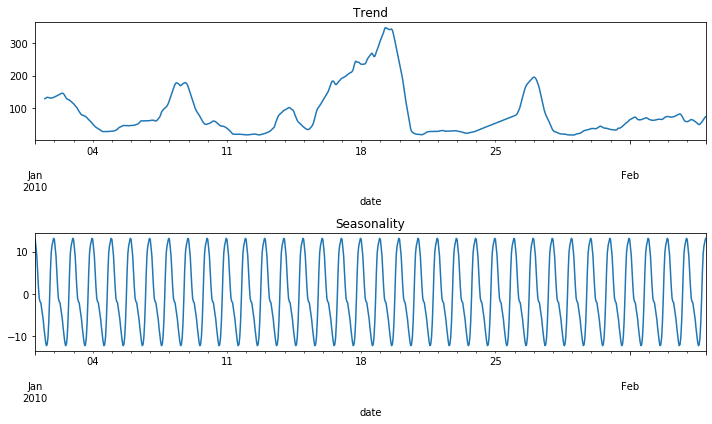

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

results=seasonal_decompose(data["PM"],model="additive")
pm_decomposed=pd.DataFrame(data={"PM_trend":results.trend,"PM_seasonal":results.seasonal})

# We don't want to plot the entire dataset because we could not clearly observe the decomposition result
vbound=5*7*24

f=plt.figure(figsize=(10,6))
f.set_tight_layout(True)
ax,ax2=f.subplots(2,1)
ax.set_title("Trend")
results.trend[:vbound].plot(ax=ax)
ax2.set_title("Seasonality")
results.seasonal[:vbound].plot(ax=ax2)

## Spectrum analysis

Text(0, 0.5, 'Frequency')

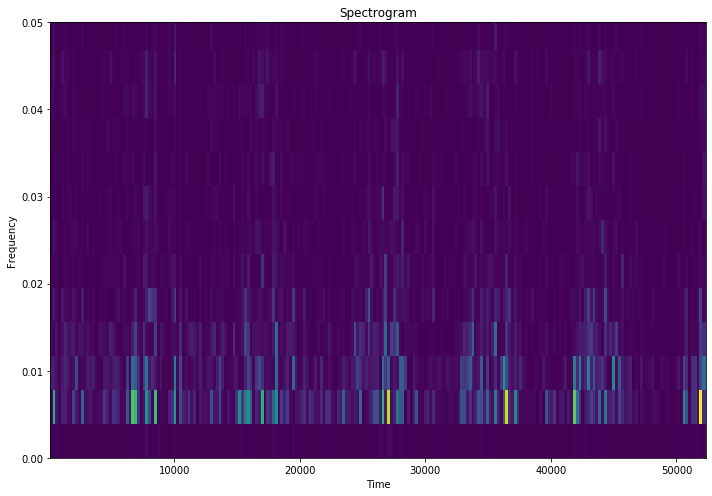

In [13]:
from scipy import signal

f,t,Sxx=signal.spectrogram(data["PM"])
fg=plt.figure(figsize=(10,7))
fg.set_tight_layout(True)
ax=plt.gca()
ax.pcolormesh(t,f,Sxx)
ax.set_title("Spectrogram")
ax.set_xlabel("Time")
ax.set_ylim(0,0.05)
ax.set_ylabel("Frequency")

It appears that there is not much information we could extract from the spectrum other than the periodicity of the colors.

## Datetime features

We used the package of [`chinese-calendar`][1] to generate attribute `is_holiday`

[1]: https://github.com/LKI/chinese-calendar

In [14]:
from datetime import date
from chinese_calendar import is_holiday

def is_holiday_func(row):
    if is_holiday(date(row["year"],row["month"],row["day"])):
        return 1
    return 0

holiday_features=data.apply(is_holiday_func,axis=1)

datetime_features=pd.DataFrame(data={"is_holiday":holiday_features})
datetime_features[::24].head()

,is_holiday
date,
2010-01-01,1
2010-01-02,1
2010-01-03,1
2010-01-04,0
2010-01-05,0


## Statistical features

```python
fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
```

In [15]:
# Mean PM2.5 concentration over the past 24 hours
mean_PM=data["PM"].rolling(window=24).mean()
max_PM=data["PM"].rolling(window=24).max()
min_PM=data["PM"].rolling(window=24).min()

pm_stats=pd.DataFrame(data={"mean_PM":mean_PM,"max_PM":max_PM,"min_PM":min_PM})
pm_stats[::12].head()

,mean_PM,max_PM,min_PM
date,,,
2010-01-01 00:00:00,NaN,NaN,NaN
2010-01-01 12:00:00,NaN,NaN,NaN
2010-01-02 00:00:00,129.791667,148.0,129.0
2010-01-02 12:00:00,134.958333,181.0,105.0
2010-01-03 00:00:00,140.791667,181.0,63.0


## TODO: Features from TSFresh

Because the dataset contains more than 50,000 entries, it will be overloading to extract them all at once using TSFresh's functionalities. Hence, we extract them month by month.

In [16]:
"""
from tsfresh import extract_relevant_features

portion=data.loc[data["date"]<"2010-01-15 00:00:00",valcols|lblcols].copy()
portion.index=portion["id"]
print("%d samples between %s and %s were selected to extract relevant features"
      % (portion.shape[0],portion["date"][0],portion["date"][portion.shape[0]-1]))
y=portion["PM"]
rel_features=extract_relevant_features(portion,y,column_id="id",column_sort="date",fdr_level=0.1)

print("%d features were extracted from the selected time series" % (rel_features.shape[1]))
"""
pass

Apparently, there are totally 100+ features extracted from the original time series; most of them tend to be similar and redundant. Consequently, we perform Principal Component Analysis to reduce dimensions.

In [17]:
"""
from sklearn.decomposition import PCA

egvals,_=np.linalg.eig(rel_features.corr())
# We only care about the magnitude of these eigenvalues, so we look at their absolute values
egvals=np.array(sorted(abs(egvals)))
pca_threshold=1e-2  # Improvement: Tune this
n_pcs=egvals[egvals>=pca_threshold].shape[0]

print("%d principal components were selected for further extraction" % n_pcs)

pca_model=PCA(n_components=n_pcs)
rel_pcs=pca_model.fit_transform(rel_features)

pc_dict={}
for i,col in enumerate(rel_pcs.T):
    pc_dict["PC{}".format(i+1)]=col

tsfresh_pcs=pd.DataFrame(data=pc_dict)
"""
pass

In [18]:
"""
plt.figure(figsize=(10,8))
plt.title("Principal components from TSFresh features")
_=tsfresh_pcs.plot(ax=plt.gca())
"""
pass

In [19]:
#tsfresh_pcs.head()

What if analysis: policy makers can use this prediction model to decide whether to hold special events to help increase air quality

## Feature Fusion

After a series of analysis, we combine the extracted features to form a new dataset for our prediction model. To handle NAN values in new features, we truncate the dataset.

In [20]:
data_combined=pd.concat([data,data_lagged,pm_decomposed,pm_stats,datetime_features],axis=1)
data_combined.index=data_combined["id"]
first_valid_idx=data_combined.apply(lambda s:s.first_valid_index(),axis=0).max()

data_final=data_combined[first_valid_idx:].copy()
data_final.index=data_final["id"]-first_valid_idx
data_final.drop("id",axis=1).to_csv("BeijingPM_features.csv")

## Training set and testing set

We treat the last two months of the dataset as the testing set (i.e. not visible by our prediction model) and regard the other portions of this dataset as the training set.

In [21]:
train_test_boundary="2015-10-01 00:00:00"

train_set=data_final[data_final["date"]<=train_test_boundary].copy().drop("id",axis=1)
train_set.to_csv("BeijingPM_train.csv")

test_set=data_final[data_final["date"]>train_test_boundary].copy()
test_set["id"]=range(test_set.shape[0])
test_set.index=test_set["id"]
test_set.drop("id",axis=1).to_csv("BeijingPM_test.csv")